In [1]:
import open3d as o3d
import numpy as np
import copy
# 定义文件路径
cube_obj_path = "mesh/cube_0.obj"
zed_ply_path = "mesh/zed_point_cloud_world.ply"

# 读取 cube_0.obj 点云
cube_mesh = o3d.io.read_triangle_mesh(cube_obj_path)
cube_mesh.compute_vertex_normals()  # 计算法线以便更好显示

# 读取 zed_point_cloud_world.ply 点云
zed_point_cloud = o3d.io.read_point_cloud(zed_ply_path)

# 打印点云和网格的信息
print("Cube mesh:")
print(cube_mesh)  
print("ZED point cloud:")
print(zed_point_cloud)


Cube mesh:
TriangleMesh with 450 points and 390 triangles.
ZED point cloud:
PointCloud with 755965 points.


In [2]:
def filter_point_cloud_by_z(pcd, z_threshold=-0.001):
    """
    过滤点云中所有 z < z_threshold 的点。
    
    Args:
        pcd (open3d.geometry.PointCloud): 输入的点云对象。
        z_threshold (float): z 轴的过滤阈值，小于该值的点将被移除。
        
    Returns:
        open3d.geometry.PointCloud: 过滤后的点云对象。
    """
    # 转换点云为 numpy 数组
    points = np.asarray(pcd.points)
    
    # 过滤 z 值小于阈值的点
    filtered_points = points[points[:, 2] >= z_threshold]
    
    # 创建新的点云对象
    filtered_pcd = o3d.geometry.PointCloud()
    filtered_pcd.points = o3d.utility.Vector3dVector(filtered_points)
    
    # 保留原始颜色（如果存在）
    if pcd.has_colors():
        colors = np.asarray(pcd.colors)
        filtered_colors = colors[points[:, 2] >= z_threshold]
        filtered_pcd.colors = o3d.utility.Vector3dVector(filtered_colors)
    
    return filtered_pcd

In [3]:
zed_point_cloud = filter_point_cloud_by_z(zed_point_cloud)
zed_point_cloud

PointCloud with 13737 points.

In [4]:
cube_point_cloud = cube_mesh.sample_points_uniformly(number_of_points=10000)  # 转为点云
cube_point_cloud

PointCloud with 10000 points.

In [5]:
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.1,  # 坐标轴大小，可以根据需要调整
    origin=[0, 0, 0]  # 坐标轴的原点
)


In [6]:
def register_and_filter(pointcloud, mesh, voxel_size=0.01):
    """
    对输入点云和网格进行配准，并返回配准变换矩阵和去除识别目标后的点云。
    
    Args:
        pointcloud (o3d.geometry.PointCloud): 输入点云
        mesh (o3d.geometry.TriangleMesh): 输入网格
        voxel_size (float): 体素大小，用于下采样
    
    Returns:
        transform (numpy.ndarray): 配准的变换矩阵
        remaining_pointcloud (o3d.geometry.PointCloud): 去除识别目标后的剩余点云
    """
    # 确保输入的 mesh 是 TriangleMesh 对象
    if isinstance(mesh, o3d.geometry.TriangleMesh):
        # 转换网格为点云
        mesh_pointcloud = mesh.sample_points_uniformly(number_of_points=1000)
    elif isinstance(mesh, o3d.geometry.PointCloud):
        # 如果已经是点云，直接使用
        mesh_pointcloud = copy.deepcopy(mesh)
    else:
        raise TypeError("Input mesh must be of type o3d.geometry.TriangleMesh or o3d.geometry.PointCloud")

    # 下采样点云并计算法线和特征
    def preprocess_point_cloud(pcd, voxel_size):
        pcd_down = pcd.voxel_down_sample(voxel_size)
        pcd_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*2, max_nn=30))
        pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            pcd_down,
            search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*5, max_nn=100))
        return pcd_down, pcd_fpfh

    # 粗配准
    def execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size):
        distance_threshold = voxel_size * 1.5
        result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
            source_down, target_down, source_fpfh, target_fpfh, True,
            distance_threshold,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
            4,  # RANSAC 采样数量
            [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
             o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
            o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 200))
        return result

    # Todo: 考虑使用PointToPlane的优化目标
    # 精配准
    def refine_registration(source, target, initial_transformation, voxel_size):
        distance_threshold = voxel_size * 1
        result = o3d.pipelines.registration.registration_icp(
            source, target, distance_threshold, initial_transformation,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            # PointToPlane
            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000000)
        )
        return result

    # 下采样点云并计算特征
    source_down, source_fpfh = preprocess_point_cloud(mesh_pointcloud, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(pointcloud, voxel_size)

    # 粗配准
    coarse_result = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)

    # 精配准
    refined_result = refine_registration(mesh_pointcloud, pointcloud, coarse_result.transformation, voxel_size)
    print(refined_result)

    # 将网格点云变换到目标点云的空间
    transform = refined_result.transformation
    transformed_mesh_pointcloud = mesh_pointcloud.transform(transform)

    # 创建包围盒裁剪目标点云
    bounding_box = transformed_mesh_pointcloud.get_axis_aligned_bounding_box()
    deleted_pointcloud = pointcloud.crop(bounding_box)  # 被删除的点
    remaining_pointcloud = pointcloud.crop(bounding_box, invert=True)  # 剩余的点

    return transform, remaining_pointcloud, deleted_pointcloud


In [22]:
transform, remaining_pointcloud, deleted_pointcloud = register_and_filter(zed_point_cloud, cube_point_cloud)

[Open3D WARNING] Too few correspondences (5) after mutual filter, fall back to original correspondences.
RegistrationResult with fitness=7.203000e-01, inlier_rmse=3.384506e-03, and correspondence_set size of 7203
Access transformation to get result.


In [24]:
transform

array([[-0.02178054, -0.52280203,  0.85217583,  0.28532087],
       [ 0.0096058 , -0.85244812, -0.52272357,  0.26581992],
       [ 0.99971663, -0.00319937,  0.02358871,  0.02074069],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [18]:
remaining_pointcloud

PointCloud with 7474 points.

In [23]:
cube_point_cloud_transormed = copy.deepcopy(cube_point_cloud)
cube_point_cloud_transormed = cube_point_cloud_transormed.transform(transform)
o3d.visualization.draw_geometries([cube_point_cloud, cube_point_cloud_transormed, zed_point_cloud, coordinate_frame],
                                  window_name="Aligned Point Clouds")

In [11]:
# 显示点云和坐标轴
o3d.visualization.draw_geometries(
    [cube_mesh, remaining_pointcloud, coordinate_frame],  # 添加坐标轴到显示列表
    window_name="Point Clouds and Mesh Display",
    width=800,
    height=600,
    left=50,
    top=50,
    mesh_show_wireframe=True
)

In [22]:
transform2, remaining_pointcloud2, deleted_pointcloud2 = register_and_filter(remaining_pointcloud, cube_point_cloud)


[Open3D WARNING] Too few correspondences (2) after mutual filter, fall back to original correspondences.
RegistrationResult with fitness=7.318000e-01, inlier_rmse=3.694957e-03, and correspondence_set size of 7318
Access transformation to get result.


In [23]:
transform

array([[-0.029901  ,  0.99907209, -0.03099815,  0.55151608],
       [ 0.03098061,  0.03192343,  0.99901006, -0.30299872],
       [ 0.99907264,  0.02891106, -0.03190641,  0.01866077],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [24]:
remaining_pointcloud2

PointCloud with 3895 points.

In [25]:
cube_point_cloud_transormed = copy.deepcopy(cube_point_cloud)
cube_point_cloud_transormed = cube_point_cloud_transormed.transform(transform)
o3d.visualization.draw_geometries([cube_point_cloud_transormed, remaining_pointcloud2, coordinate_frame],
                                  window_name="Aligned Point Clouds")

In [26]:
transform3, remaining_pointcloud3, deleted_pointcloud3 = register_and_filter(remaining_pointcloud2, cube_point_cloud)


[Open3D WARNING] Too few correspondences (4) after mutual filter, fall back to original correspondences.
RegistrationResult with fitness=7.228000e-01, inlier_rmse=3.587330e-03, and correspondence_set size of 7228
Access transformation to get result.


In [27]:
transform3

array([[-0.03746295,  0.37215917,  0.92741257,  0.47366863],
       [ 0.04844664, -0.92629636,  0.37366826, -0.13654242],
       [ 0.99812296,  0.05892874,  0.01667193,  0.01939211],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [28]:
remaining_pointcloud3

PointCloud with 19 points.

In [25]:
cube_point_cloud_transormed = copy.deepcopy(cube_point_cloud)
cube_point_cloud_transormed = cube_point_cloud_transormed.transform(transform)
o3d.visualization.draw_geometries([cube_point_cloud_transormed, remaining_pointcloud3, coordinate_frame],
                                  window_name="Aligned Point Clouds")

NameError: name 'remaining_pointcloud3' is not defined

In [26]:
o3d.visualization.draw_geometries([deleted_pointcloud, coordinate_frame],
                                  window_name="Aligned Point Clouds")

In [27]:

import scipy.ndimage
import matplotlib.pyplot as plt

In [28]:
def pointcloud_to_top_view_image(pointcloud, voxel_size=0.01, output_image_size=(512, 512)):
    """
    从点云生成正上方的 2D 图像。
    
    Args:
        pointcloud (o3d.geometry.PointCloud): 输入点云
        voxel_size (float): 分辨率，用于划分网格
        output_image_size (tuple): 输出图像大小 (width, height)
    
    Returns:
        top_view_image (numpy.ndarray): 生成的 2D 图像
    """
    # 获取点云的点坐标
    points = np.asarray(pointcloud.points)

    # 提取 x-y 范围
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)

    # 定义网格分辨率
    width, height = output_image_size
    grid_x = np.linspace(x_min, x_max, width)
    grid_y = np.linspace(y_min, y_max, height)

    # 初始化 2D 图像
    top_view_image = np.zeros((height, width))

    # 遍历点云，将每个点投影到网格上
    for point in points:
        x, y, z = point
        # 找到对应的网格索引
        x_idx = int((x - x_min) / (x_max - x_min) * (width - 1))
        y_idx = int((y - y_min) / (y_max - y_min) * (height - 1))
        # 在对应网格中记录高度（或其他属性）
        top_view_image[height - 1 - y_idx, x_idx] += z  # 使用高度作为灰度值

    # 归一化图像
    top_view_image -= np.min(top_view_image)
    top_view_image /= np.max(top_view_image)

    return top_view_image




In [29]:
import numpy as np
import open3d as o3d

def pointcloud_to_top_view_image_color(pointcloud, voxel_size=0.01, output_image_size=(512, 512)):
    """
    从点云生成正上方的彩色 2D 图像。
    
    Args:
        pointcloud (o3d.geometry.PointCloud): 输入点云
        voxel_size (float): 分辨率，用于划分网格
        output_image_size (tuple): 输出图像大小 (width, height)
    
    Returns:
        top_view_image (numpy.ndarray): 生成的 2D 彩色图像
    """
    # 获取点云的点坐标和颜色
    points = np.asarray(pointcloud.points)
    colors = np.asarray(pointcloud.colors) if pointcloud.has_colors() else np.zeros_like(points)

    # 提取 x-y 范围
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)
    print(x_max, y_max)

    # 定义网格分辨率
    width, height = output_image_size
    grid_x = np.linspace(x_min, x_max, width)
    grid_y = np.linspace(y_min, y_max, height)

    # 初始化 2D 彩色图像
    top_view_image = np.zeros((height, width, 3))  # RGB 图像

    # 初始化计数矩阵以累积颜色
    count_matrix = np.zeros((height, width))

    # 遍历点云，将每个点投影到网格上
    for point, color in zip(points, colors):
        x, y, z = point
        # 找到对应的网格索引
        x_idx = int((x - x_min) / (x_max - x_min) * (width - 1))
        y_idx = int((y - y_min) / (y_max - y_min) * (height - 1))
        
        # 更新彩色图像和计数矩阵
        top_view_image[height - 1 - y_idx, x_idx] += color  # 累加颜色
        count_matrix[height - 1 - y_idx, x_idx] += 1

    # 平均化颜色值
    nonzero_mask = count_matrix > 0
    top_view_image[nonzero_mask] /= count_matrix[nonzero_mask, None]

    # 将结果归一化到 0-1 范围内
    top_view_image = np.clip(top_view_image, 0, 1)

    return top_view_image


In [30]:
# 创建一个沿 Y 轴旋转的变换矩阵
def create_rotation_matrix_y(theta):
    """
    创建沿 Y 轴旋转的 4x4 仿射变换矩阵。
    
    Args:
        theta (float): 绕 Y 轴旋转的角度（弧度）。
    
    Returns:
        np.ndarray: 4x4 仿射变换矩阵。
    """
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotation_matrix = np.array([
        [cos_theta, 0, sin_theta, 0],
        [0, 1, 0, 0],
        [-sin_theta, 0, cos_theta, 0],
        [0, 0, 0, 1]
    ])
    return rotation_matrix

In [38]:
deleted_pointcloud_transformed = copy.deepcopy(deleted_pointcloud)
transformer_inv = np.linalg.inv(transform)
deleted_pointcloud_transformed.transform(transformer_inv)
# 生成 Y 轴旋转矩阵（π弧度）
rotation_matrix_y = create_rotation_matrix_y(-np.pi/2)

# 在 transformed 点云上再应用 Y 轴旋转
deleted_pointcloud_transformed.transform(rotation_matrix_y)
# 生成正上方的彩色 2D 图像
top_view_image_color = pointcloud_to_top_view_image_color(deleted_pointcloud_transformed)
o3d.visualization.draw_geometries([deleted_pointcloud, deleted_pointcloud_transformed, coordinate_frame],
                                  window_name="Aligned Point Clouds")

0.02231553791047393 0.022557249875079066


In [39]:
import scipy.ndimage

def interpolate_sparse_image(image, dilation_size=(7, 7)):
    """
    对稀疏的彩色图像进行插值填充。
    
    Args:
        image (numpy.ndarray): 输入彩色图像 (height, width, 3)
        dilation_size (tuple): 膨胀操作的邻域大小 (height, width)
    
    Returns:
        interpolated_image (numpy.ndarray): 插值后的彩色图像
    """
    interpolated_image = image.copy()
    for i in range(3):  # 分别处理 RGB 三个通道
        interpolated_image[:, :, i] = scipy.ndimage.morphology.grey_dilation(
            image[:, :, i], size=dilation_size
        )
    return interpolated_image

C:\Users\lvxiangyu11\AppData\Local\Temp\ipykernel_377396\1455669674.py:16: DeprecationWarning: Please import `grey_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  interpolated_image[:, :, i] = scipy.ndimage.morphology.grey_dilation(


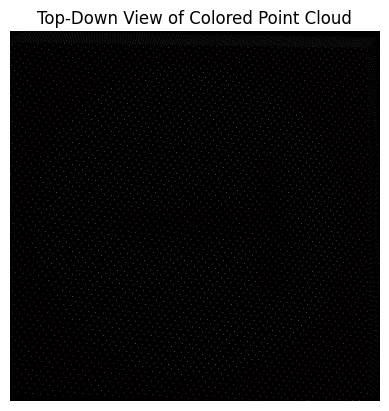

In [40]:
import matplotlib.pyplot as plt
top_view_image_color_interpolated = interpolate_sparse_image(top_view_image_color, dilation_size=(15, 15))
# 显示图像
plt.imshow(top_view_image_color)
plt.title("Top-Down View of Colored Point Cloud")
plt.axis("off")
plt.show()


In [41]:
import numpy as np

def max_downsample_image(image, pool_size=(2, 2)):
    """
    使用最大值池化对图像进行降采样。

    Args:
        image (numpy.ndarray): 输入彩色图像 (height, width, 3)
        pool_size (tuple): 池化窗口大小 (height, width)

    Returns:
        downsampled_image (numpy.ndarray): 降采样后的图像
    """
    h, w, c = image.shape
    ph, pw = pool_size

    # 确保图像尺寸是池化窗口的整数倍
    h_new = h // ph * ph
    w_new = w // pw * pw
    image_cropped = image[:h_new, :w_new, :]

    # 使用最大池化降采样
    downsampled_image = image_cropped.reshape(h_new // ph, ph, w_new // pw, pw, c).max(axis=(1, 3))

    return downsampled_image

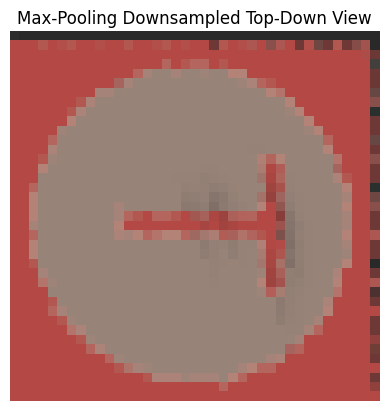

<Figure size 640x480 with 0 Axes>

In [42]:
# 使用最大值池化进行降采样
downsampled_image_max = max_downsample_image(top_view_image_color, pool_size=(13, 13))

# 显示降采样后的图像
plt.imshow(downsampled_image_max)
plt.title("Max-Pooling Downsampled Top-Down View")
plt.axis("off")
plt.show()
plt.savefig("test.png")

In [43]:
from PIL import Image
# 将数组转换为 0-255 范围的整数值以适应 PNG 格式
downsampled_image_uint8 = (downsampled_image_max * 255).astype(np.uint8)

# 创建 PIL 图像对象
image_to_save = Image.fromarray(downsampled_image_uint8)

# 保存图像为 test.png
image_to_save.save("test.png")

In [52]:
import matplotlib.pyplot as plt


In [39]:
from PIL import Image

deleted_pointcloud_transformed2 = copy.deepcopy(deleted_pointcloud2)
transformer_inv2 = np.linalg.inv(transform2)
deleted_pointcloud_transformed2.transform(transformer_inv2)
# 生成 Y 轴旋转矩阵（π弧度）
rotation_matrix_y = create_rotation_matrix_y(np.pi)

# 在 transformed 点云上再应用 Y 轴旋转
deleted_pointcloud_transformed2.transform(rotation_matrix_y)
o3d.visualization.draw_geometries([deleted_pointcloud2, deleted_pointcloud_transformed2, coordinate_frame],
                                  window_name="Aligned Point Clouds")
# 生成正上方的彩色 2D 图像
top_view_image_color2 = pointcloud_to_top_view_image_color(deleted_pointcloud_transformed2)
downsampled_image_max2 = max_downsample_image(top_view_image_color2, pool_size=(13, 13))

from PIL import Image
# 将数组转换为 0-255 范围的整数值以适应 PNG 格式
downsampled_image_uint82 = (downsampled_image_max2 * 255).astype(np.uint8)

# 创建 PIL 图像对象
image_to_save = Image.fromarray(downsampled_image_uint82)

# 保存图像为 test.png
image_to_save.save("test2.png")

0.0195010724823859 0.023692413926928668


In [40]:
from PIL import Image

deleted_pointcloud_transformed2 = copy.deepcopy(deleted_pointcloud2)
transformer_inv2 = np.linalg.inv(transform2)
deleted_pointcloud_transformed2.transform(transformer_inv2)
# 生成 Y 轴旋转矩阵（π弧度）
rotation_matrix_y = create_rotation_matrix_y(np.pi)

# 在 transformed 点云上再应用 Y 轴旋转
deleted_pointcloud_transformed2.transform(rotation_matrix_y)
o3d.visualization.draw_geometries([deleted_pointcloud2, deleted_pointcloud_transformed2, coordinate_frame],
                                  window_name="Aligned Point Clouds")
# 生成正上方的彩色 2D 图像
top_view_image_color2 = pointcloud_to_top_view_image_color(deleted_pointcloud_transformed2)
downsampled_image_max2 = max_downsample_image(top_view_image_color2, pool_size=(13, 13))

from PIL import Image
# 将数组转换为 0-255 范围的整数值以适应 PNG 格式
downsampled_image_uint82 = (downsampled_image_max2 * 255).astype(np.uint8)

# 创建 PIL 图像对象
image_to_save = Image.fromarray(downsampled_image_uint82)

# 保存图像为 test.png
image_to_save.save("test2.png")

0.0195010724823859 0.023692413926928668


0.022301313928595357 0.02463805191668711


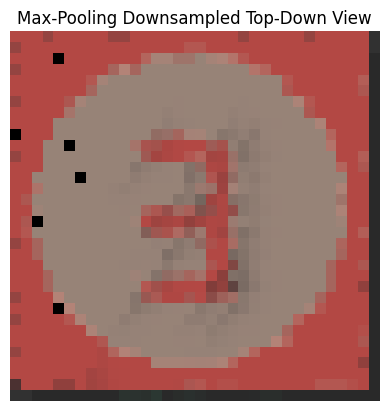

<Figure size 640x480 with 0 Axes>

In [62]:
from PIL import Image

deleted_pointcloud_transformed3 = copy.deepcopy(deleted_pointcloud3)
transformer_inv3 = np.linalg.inv(transform3)
deleted_pointcloud_transformed3.transform(transformer_inv3)
# 生成 Y 轴旋转矩阵（π弧度）
rotation_matrix_y = create_rotation_matrix_y(-np.pi/2)

# 在 transformed 点云上再应用 Y 轴旋转
deleted_pointcloud_transformed3.transform(rotation_matrix_y)
o3d.visualization.draw_geometries([deleted_pointcloud_transformed3, coordinate_frame],
                                  window_name="Aligned Point Clouds")
# 生成正上方的彩色 2D 图像
top_view_image_color3 = pointcloud_to_top_view_image_color(deleted_pointcloud_transformed3)
downsampled_image_max3 = max_downsample_image(top_view_image_color3, pool_size=(15, 15))

plt.imshow(downsampled_image_max3)
plt.title("Max-Pooling Downsampled Top-Down View")
plt.axis("off")
plt.show()
plt.savefig("test.png")

# 将数组转换为 0-255 范围的整数值以适应 PNG 格式
downsampled_image_uint83 = (downsampled_image_max3 * 255).astype(np.uint8)

# 创建 PIL 图像对象
image_to_save = Image.fromarray(downsampled_image_uint83)

# 保存图像为 test.png
image_to_save.save("test2.png")

# 尝试使用LLM，废弃

In [24]:
with open("test3.png", "rb") as image_file:
    image_base64 = base64.b64encode(image_file.read()).decode("utf-8")


NameError: name 'base64' is not defined

In [234]:
import requests
import base64

# 定义主机地址和端口
host = "192.168.3.111"
port = "11434"
url = f"http://{host}:{port}"
model = "llava:7b"

prompt = """请根据图片内容完成以下JSON数组，并仅返回该数组，禁止任何解释或额外描述。请严格按照以下要求填写： 
{
  "text_color": 从 "Blue", "Green", "Yellow", "Red", "Wood" 中选择一个最接近的颜色作为值，
  "has_circle": 布尔值 true 或 false，表示背景颜色和字母颜色是否一致，
  "text_content": 仅包含图片中的一个字母，不可为空或包含其他内容。
}
请确保回答格式与示例完全一致。
"""

In [239]:
from ollama import Client
client = Client(
  host=url,
  headers={'x-some-header': 'some-value'}
)
response = client.chat(model=model, messages=[
  {
    'role': 'user',
    'content': prompt,
    'images': [image_base64]
  },
])
response

ChatResponse(model='llava:7b', created_at='2024-11-29T18:27:06.671301024Z', done=True, done_reason='stop', total_duration=2284509178, load_duration=3455427, prompt_eval_count=1, prompt_eval_duration=1254644000, eval_count=40, eval_duration=968752000, message=Message(role='assistant', content=' ```json\n{\n  "text_color": "Blue",\n  "has_circle": false,\n  "text_content": "R"\n}\n``` ', images=None, tool_calls=None))

In [240]:
message_content = response["message"]["content"]
message_content

' ```json\n{\n  "text_color": "Blue",\n  "has_circle": false,\n  "text_content": "R"\n}\n``` '

In [241]:
import re

# 使用正则表达式提取 JSON 数据块
cleaned_json_match = re.search(r"```json\s*(\{.*?\})\s*```", message_content, re.DOTALL)
cleaned_json_match.group(1)


'{\n  "text_color": "Blue",\n  "has_circle": false,\n  "text_content": "R"\n}'

In [232]:
parsed_json = json.loads(cleaned_json_match.group(1))
parsed_json

{'text_color': 'Red', 'has_circle': True, 'text_content': 'T'}

In [223]:
def getCubeInformationFromLLAVA(img_path, host="192.168.3.111", ):
    

SyntaxError: incomplete input (162203901.py, line 2)